In [ ]:
from google.colab import files
files.upload()   # pilih file kaggle.json yang kamu download dari Kaggle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wandyf","key":"f4383aa11abe4323bd0fbdd98efc4592"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d wandyf/cloudsets
!unzip cloudsets.zip -d dataset


Dataset URL: https://www.kaggle.com/datasets/wandyf/cloudsets
License(s): CC0-1.0
 94% 154M/163M [00:00<00:00, 1.60GB/s]
100% 163M/163M [00:00<00:00, 1.58GB/s]
Archive:  cloudsets.zip
  inflating: dataset/DATASETS/test/Cumulonimbus/1Q3CMzgWy7n8.png  
  inflating: dataset/DATASETS/test/Cumulonimbus/27awan_Cumulonimbus.png  
  inflating: dataset/DATASETS/test/Cumulonimbus/4bcd8e8613bd439a782f071f239bdd08 (1).jpeg  
  inflating: dataset/DATASETS/test/Cumulonimbus/Fire cloud.jpeg  
  inflating: dataset/DATASETS/test/Cumulonimbus/download (3).jpeg  
  inflating: dataset/DATASETS/test/Cumulus/istockphoto-123125679-612x612.jpg  
  inflating: dataset/DATASETS/test/Cumulus/istockphoto-157335483-612x612.jpg  
  inflating: dataset/DATASETS/test/Cumulus/istockphoto-172965212-612x612.jpg  
  inflating: dataset/DATASETS/test/Cumulus/istockphoto-483056518-612x612.jpg  
  inflating: dataset/DATASETS/test/Cumulus/istockphoto-91248843-612x612.jpg  
  inflating: dataset/DATASETS/test/Nimbosratus/istockph

In [ ]:
train_path = "/content/dataset/DATASETS/train"
test_path  = "/content/dataset/DATASETS/test"


In [ ]:
!ls /content/dataset/DATASETS/
!ls /content/dataset/DATASETS/test

test  train
Cumulonimbus  Cumulus  Nimbosratus  Stratocumulus  Stratus


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn;
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import cv2
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
#persiapan data dan konfigurasi sebelum proses pelatihan model
class_names = [
    "Cumulonimbus",
    "Cumulus",
    "Nimbostratus",
    "Stratocumulus",
    "Stratus"
]

class_names_label = {name: i for i, name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [ ]:
def load_data(dataset_path):
    images = []
    labels = []

    print("Loading:", dataset_path)

    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)

        if class_name not in class_names_label:
            print("Skip:", class_name)
            continue

        label = class_names_label[class_name]

        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)

            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print("Rusak / tidak terbaca:", img_path)
                continue

            # Tangani grayscale
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # Tangani RGBA
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

            try:
                img = cv2.resize(img, (224, 224))
            except:
                print("Resize gagal:", img_path)
                continue

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)


In [ ]:
!mv /content/dataset/DATASETS/test/Nimbosratus /content/dataset/DATASETS/test/Nimbostratus


In [ ]:
!ls /content/dataset/DATASETS/test

Cumulonimbus  Cumulus  Nimbostratus  Stratocumulus  Stratus


In [ ]:
train_images, train_labels = load_data(train_path)
test_images,  test_labels  = load_data(test_path)

Loading: /content/dataset/DATASETS/train
Loading: /content/dataset/DATASETS/test


In [ ]:
#fungsi shuffle untuk mengacak urutan data dalam train_images dan train_labels
train_images, train_labels = shuffle(train_images, train_labels, random_state=5)

In [ ]:
#menampilkan informasi ukuran dataset dan ukuran gambar
n_train = train_images.shape[0]
n_test = test_images.shape[0]

print("Training Examples = {}".format(n_train))
print("Testing Examples = {}".format(n_test))
print("Image Size = {}".format(IMAGE_SIZE))

Training Examples = 2749
Testing Examples = 25
Image Size = (224, 224)


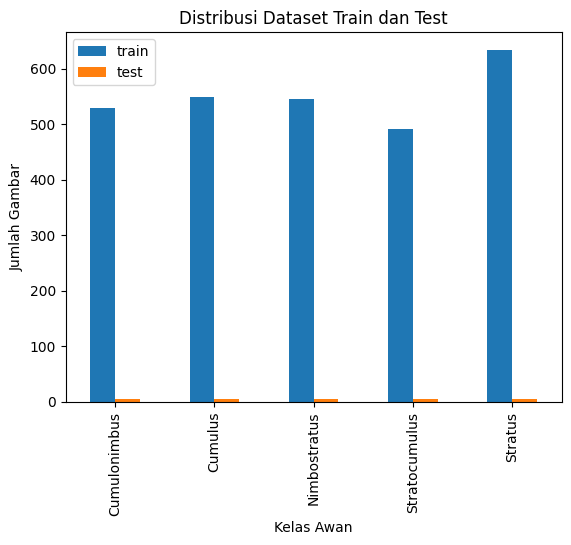

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class_names = [
    "Cumulonimbus",
    "Cumulus",
    "Nimbostratus",
    "Stratocumulus",
    "Stratus"
]


# Hitung jumlah untuk setiap kelas (0–4)
train_counts = [np.sum(train_labels == i) for i in range(len(class_names))]
test_counts  = [np.sum(test_labels == i) for i in range(len(class_names))]

df = pd.DataFrame({
    'train': train_counts,
    'test': test_counts
}, index=class_names)

df.plot.bar()
plt.xlabel("Kelas Awan")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Dataset Train dan Test")
plt.show()


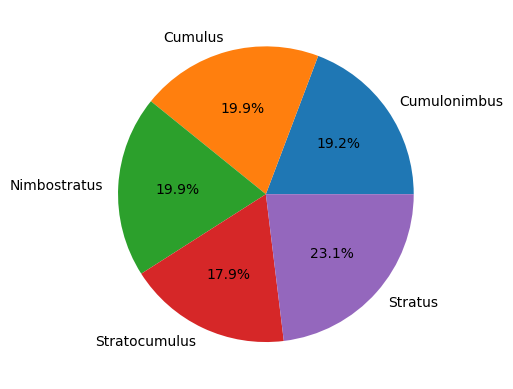

In [ ]:
plt.pie(train_counts, labels=class_names, autopct='%1.1f%%')
plt.show()

In [ ]:
train_images = train_images.astype("float32") / 255.0
test_images  = test_images.astype("float32")  / 255.0


In [ ]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])

    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.title("Image #{}".format(index+1)+" "+class_names[labels[index]])
    plt.show()

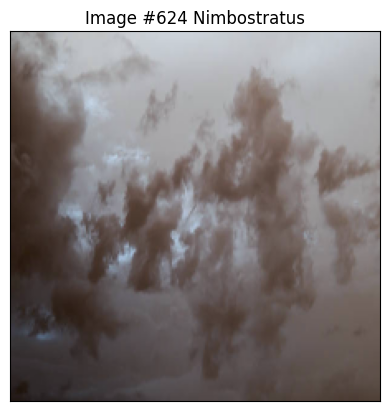

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Examples",fontsize=12)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(class_names[labels[i]])
    plt.show()

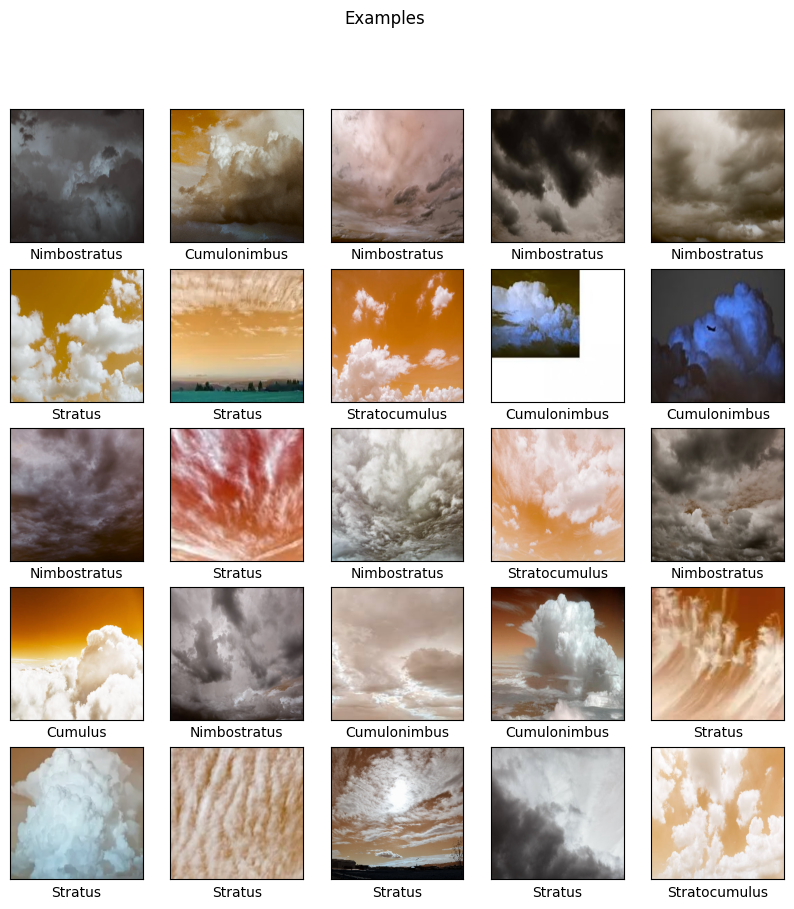

In [ ]:
display_examples(class_names, train_images, train_labels)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load VGG16 tanpa top
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer awal
for layer in vgg16_base.layers[:-5]:
    layer.trainable = False

# Tambahkan classifier di atas VGG16
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(50, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Gabungkan feature extractor + classifier
model = Model(inputs=vgg16_base.input, outputs=output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train langsung pakai train_images (BUKAN train_features)
history = model.fit(
    train_images, train_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 51s 507ms/step - accuracy: 0.3146 - loss: 1.5715 - val_accuracy: 0.6255 - val_loss: 0.9294
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.6411 - loss: 0.9165 - val_accuracy: 0.7636 - val_loss: 0.6863
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.8256 - loss: 0.5297 - val_accuracy: 0.7655 - val_loss: 0.6344
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.8279 - loss: 0.4127 - val_accuracy: 0.8273 - val_loss: 0.4773
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.8598 - loss: 0.3825 - val_accuracy: 0.8200 - val_loss: 0.5336
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step - accuracy: 0.9004 - loss: 0.2705 - val_accuracy: 0.8164 - val_loss: 0.4857
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step - accuracy: 0.9112 - loss: 0.2345 - val_accuracy: 0.8127 - val_loss: 0.6974
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 224m

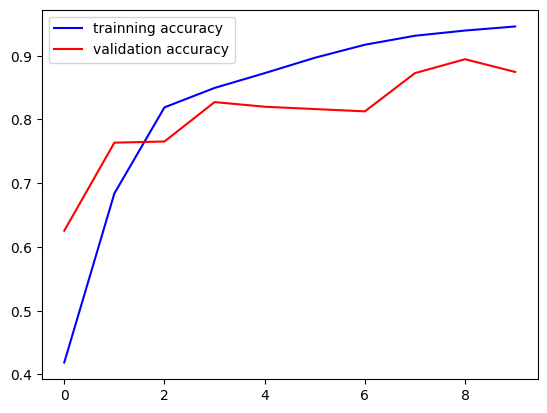

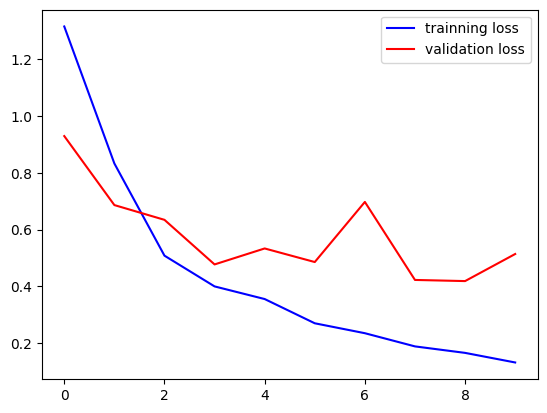

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


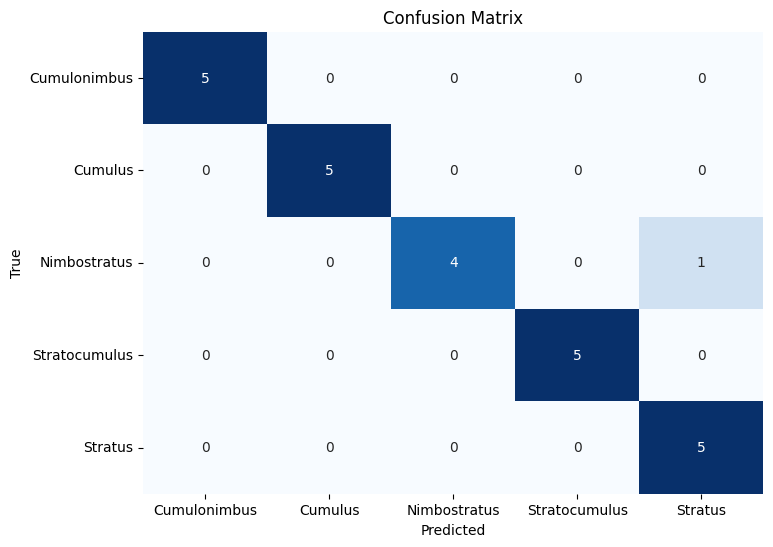

In [ ]:
import seaborn as sns

test_predictions = model.predict(test_images)
test_predictions_labels = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_labels, test_predictions_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Pastikan data test sinkron
print("Jumlah test_images :", len(test_images))
print("Jumlah test_labels :", len(test_labels))

# Prediksi ulang (WAJIB)
test_prediction = model.predict(test_images)
test_prediction_label = np.argmax(test_prediction, axis=1)

print("Jumlah prediksi :", len(test_prediction_label))

# Daftar label sesuai jumlah kelas
labels = list(range(len(class_names)))

# Classification Report
print(
    classification_report(
        test_labels,
        test_prediction_label,
        labels=labels,
        target_names=class_names,
        zero_division=0
    )
)


Jumlah test_images : 25
Jumlah test_labels : 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Jumlah prediksi : 25
               precision    recall  f1-score   support

 Cumulonimbus       1.00      1.00      1.00         5
      Cumulus       1.00      1.00      1.00         5
 Nimbostratus       1.00      0.80      0.89         5
Stratocumulus       1.00      1.00      1.00         5
      Stratus       0.83      1.00      0.91         5

     accuracy                           0.96        25
    macro avg       0.97      0.96      0.96        25
 weighted avg       0.97      0.96      0.96        25



In [ ]:
from tensorflow.keras.preprocessing import image

# Preprocessing gambar
def load_and_preprocess_image(path, target_size=(224, 224)):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img)
    img = img.astype("float32") / 255.0
    return np.expand_dims(img, axis=0)

# Prediksi awan
def awan_prediction(new_image):
    img_array = load_and_preprocess_image(new_image, target_size=(224,224))

    test_image = image.load_img(new_image, target_size=(224,224))
    plt.imshow(test_image)
    plt.axis("off")
    plt.show()

    predicted_array = model.predict(img_array)
    pred_label = class_names[np.argmax(predicted_array)]
    pred_conf = round(np.max(predicted_array) * 100, 2)

    print("Awan ini adalah:", pred_label, "dengan confidence:", pred_conf, "%")

In [ ]:
# awan_prediction("/content/dataset/DATA_SET_AWAN/test/Stratocumulus/awan-cumulus-dengan-langit-biru (3).jpeg")

In [ ]:
def upload_and_predict():
    uploaded = files.upload()
    for fname in uploaded.keys():
        print(f"\nMemprediksi file: {fname}")
        awan_prediction(fname)


Saving WhatsApp Image 2025-12-17 at 00.19.31.jpeg to WhatsApp Image 2025-12-17 at 00.19.31.jpeg

Memprediksi file: WhatsApp Image 2025-12-17 at 00.19.31.jpeg


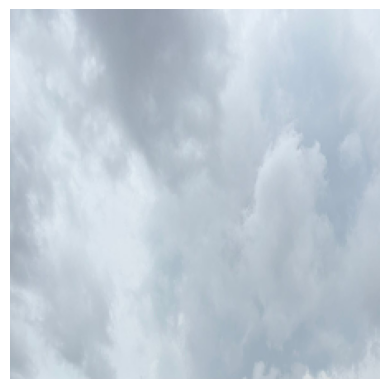

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Awan ini adalah: Nimbostratus dengan confidence: 86.02 %


In [ ]:
upload_and_predict()


In [ ]:
model.save("model-vgg16.keras")
